## Cost Analysis of Eggs
Dates are from January 1st 2019 to December 31st 2024. Based on grade A Large eggs, both conventionally and organically produced and sold in the United States. The data source is https://marsapi.ams.usda.gov/. 

In [1]:
import os
import csv
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
# Load the csv file
csv_path = Path("Resources/5_year_eggs.csv")
csv_path_2 = Path("Resources/USDA_Eggs_5_Years.csv")
csv_path_3 = Path("Resources/commercial-backyard-flocks.csv")

In [3]:
# Read in CSV file and create a DataFrame
usda_5y = pd.read_csv("Resources/USDA_Eggs_5_Years.csv")

# Remove columns
usda_5y.drop(['office_name', 'office_code', 'office_city', 'office_state', 'published_date', 'commodity', 'slug_id', 'slug_name',
                'report_title', 'final_ind', 'report_date', 'community', 'condition', 'price_unit', 'price_min', 'price_max'], axis=1, inplace=True)
# Filter for shell egg and package size 12
filtered_usda = usda_5y.loc[(usda_5y["section"] == "Shell Egg")]
filtered_usda = usda_5y.loc[(usda_5y["store_count"] > 0)]
filtered_usda

# Find the weighted data_frame for true average
weighted_usda = filtered_usda[["report_begin_date", "report_end_date", "region", "section", "type", "quality_grade", "package_size", "environment", "price_avg", "store_count"]]
weighted_usda["weighted"] = weighted_usda["price_avg"] * weighted_usda["store_count"] 
weighted_usda["weighted"]= weighted_usda["weighted"] / weighted_usda["store_count"].sum()

weighted_usda.head()

,report_begin_date,report_end_date,region,section,type,quality_grade,package_size,environment,price_avg,store_count,weighted
0,1/5/2019,1/11/2019,National,Shell Egg,WHITE LARGE,AA,NaN,Conventional,1.26,140.0,0.000033
1,1/5/2019,1/11/2019,National,Shell Egg,WHITE LARGE,AA,NaN,Conventional,2.24,188.0,0.000079
2,1/5/2019,1/11/2019,National,Shell Egg,WHITE EXTRA LARGE,A,NaN,Conventional,2.00,288.0,0.000108
3,1/5/2019,1/11/2019,National,Shell Egg,WHITE LARGE,A,NaN,Conventional,1.11,1404.0,0.000291
4,1/5/2019,1/11/2019,National,Shell Egg,WHITE LARGE,A,NaN,Conventional,2.61,231.0,0.000113


In [4]:
# Convert column report_end_date to datetime and extract the month and year
weighted_usda["report_end_date"] = pd.to_datetime(weighted_usda["report_end_date"], format="%m/%d/%Y")
weighted_usda["month"] = weighted_usda["report_end_date"].dt.month
weighted_usda["year"] = weighted_usda["report_end_date"].dt.year
weighted_usda.head()

,report_begin_date,report_end_date,region,section,type,quality_grade,package_size,environment,price_avg,store_count,weighted,month,year
0,1/5/2019,2019-01-11,National,Shell Egg,WHITE LARGE,AA,NaN,Conventional,1.26,140.0,0.000033,1,2019
1,1/5/2019,2019-01-11,National,Shell Egg,WHITE LARGE,AA,NaN,Conventional,2.24,188.0,0.000079,1,2019
2,1/5/2019,2019-01-11,National,Shell Egg,WHITE EXTRA LARGE,A,NaN,Conventional,2.00,288.0,0.000108,1,2019
3,1/5/2019,2019-01-11,National,Shell Egg,WHITE LARGE,A,NaN,Conventional,1.11,1404.0,0.000291,1,2019
4,1/5/2019,2019-01-11,National,Shell Egg,WHITE LARGE,A,NaN,Conventional,2.61,231.0,0.000113,1,2019


In [5]:
# start the weighted average calculation by multipling the avg and store count
group_year_month = weighted_usda[["price_avg", "store_count", "weighted", "month", "year"]]
group_year_month["weighted_yearly"] = weighted_usda["price_avg"] * weighted_usda["store_count"]
group_year_month.head()

/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_33599/1053679360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_year_month["weighted_yearly"] = weighted_usda["price_avg"] * weighted_usda["store_count"]


,price_avg,store_count,weighted,month,year,weighted_yearly
0,1.26,140.0,0.000033,1,2019,176.40
1,2.24,188.0,0.000079,1,2019,421.12
2,2.00,288.0,0.000108,1,2019,576.00
3,1.11,1404.0,0.000291,1,2019,1558.44
4,2.61,231.0,0.000113,1,2019,602.91


In [6]:
# iterate over the rows and calculate the weighted average, group by month and year
weighted_year_month = group_year_month.groupby(["year", "month"]).apply(lambda x: x["weighted_yearly"].sum() / x["store_count"].sum()).reset_index()
# assign column names
weighted_year_month.columns = ["year", "month", "weighted_monthly"]
weighted_year_month.head()

/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_33599/2934143590.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_year_month = group_year_month.groupby(["year", "month"]).apply(lambda x: x["weighted_yearly"].sum() / x["store_count"].sum()).reset_index()


,year,month,weighted_monthly
0,2019,1,2.477714
1,2019,2,2.681870
2,2019,3,2.624465
3,2019,4,2.530690
4,2019,5,2.241598


In [7]:
# create a new dataframe that combines the weighted average and the store count grouped by year and month
store_count_summary = group_year_month.groupby(['year', 'month'])['store_count'].sum().reset_index()
store_count_summary.head()

,year,month,store_count
0,2019,1,65665.0
1,2019,2,76943.0
2,2019,3,100942.0
3,2019,4,103933.0
4,2019,5,120812.0


In [8]:
year_month_summary = pd.merge(weighted_year_month, store_count_summary, on=["year", "month"], how="inner")
year_month_summary["Year and Month"] = pd.to_datetime(year_month_summary["month"].astype(str) + '-' + year_month_summary["year"].astype(str), dayfirst=True)
year_month_summary.set_index("Year and Month", inplace=True)
year_month_summary

/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_33599/3390167591.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  year_month_summary["Year and Month"] = pd.to_datetime(year_month_summary["month"].astype(str) + '-' + year_month_summary["year"].astype(str), dayfirst=True)


,year,month,weighted_monthly,store_count
Year and Month,,,,
2019-01-01,2019,1,2.477714,65665.0
2019-02-01,2019,2,2.681870,76943.0
2019-03-01,2019,3,2.624465,100942.0
2019-04-01,2019,4,2.530690,103933.0
2019-05-01,2019,5,2.241598,120812.0
...,...,...,...,...
2024-08-01,2024,8,3.030617,43560.0
2024-09-01,2024,9,4.564761,38530.0
2024-10-01,2024,10,5.256271,40006.0


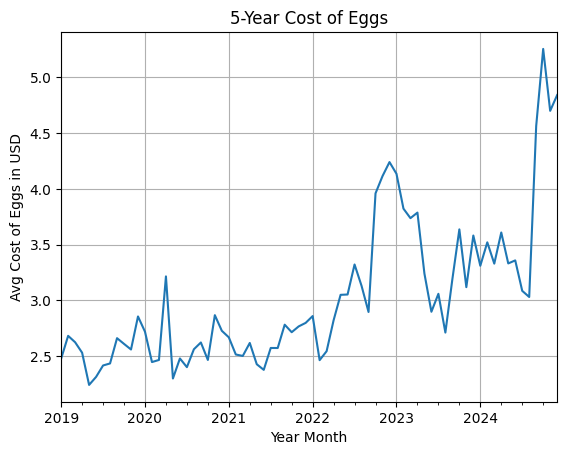

In [9]:
# Create a line graph of the change in cost in eggs over 5 years. 
year_month_summary.plot(kind="line", y="weighted_monthly", legend=False)
plt.xlabel("Year Month")
plt.ylabel("Avg Cost of Eggs in USD")
plt.title("5-Year Cost of Eggs")
plt.grid(True)
# save the figure
plt.savefig("Resources/output_data/fig1_line.png")
plt.show()

In [10]:
# Print the dataframe for reference
group_year_month.head()

,price_avg,store_count,weighted,month,year,weighted_yearly
0,1.26,140.0,0.000033,1,2019,176.40
1,2.24,188.0,0.000079,1,2019,421.12
2,2.00,288.0,0.000108,1,2019,576.00
3,1.11,1404.0,0.000291,1,2019,1558.44
4,2.61,231.0,0.000113,1,2019,602.91


In [11]:
# Calculate the delta between the low and high point for each year
min_max = group_year_month.groupby("year")["price_avg"].agg(["min", "max"])
min_max["delta"] = min_max["max"] - min_max["min"]
min_max

,min,max,delta
year,,,
2019,0.29,6.91,6.62
2020,0.32,6.99,6.67
2021,0.47,6.99,6.52
2022,0.66,8.99,8.33
2023,0.49,13.69,13.20
2024,0.78,19.99,19.21


In [12]:
# Calculate the mean per year. Perform a weighted avg calculation grouped by year
mean = group_year_month.groupby(["year"]).apply(lambda x: x["weighted_yearly"].sum() / x["store_count"].sum(),
                                                                  include_groups=False)
mean.columns = ["year", "weighted avg per year"]
mean

year
2019    2.537918
2020    2.598919
2021    2.624878
2022    2.961832
2023    3.263496
2024    3.848729
dtype: float64

In [13]:
# Calculate the median per year. 
median = group_year_month.groupby("year")["price_avg"].median()
median.columns = ["median"]
median

year
2019    2.49
2020    2.50
2021    2.50
2022    2.99
2023    3.36
2024    3.99
Name: price_avg, dtype: float64

In [14]:
# Calculate the variance in the price average per year
var = group_year_month.groupby("year")["price_avg"].var()
var.columns = ["variance"]
var

year
2019    1.356717
2020    1.309031
2021    1.177113
2022    1.428125
2023    2.091872
2024    3.265265
Name: price_avg, dtype: float64

In [15]:
# Calculate the standard deviation of the price average
std_dev = group_year_month.groupby("year")["price_avg"].std()
std_dev.columns = ["Standard Deviation"]
std_dev

year
2019    1.164782
2020    1.144129
2021    1.084948
2022    1.195042
2023    1.446330
2024    1.807004
Name: price_avg, dtype: float64

In [16]:
# calculate the SEM for the dataset
sem = std_dev/np.sqrt(std_dev).count()
sem.columns = ["Standard Error of Mean"]
sem

year
2019    0.194130
2020    0.190688
2021    0.180825
2022    0.199174
2023    0.241055
2024    0.301167
Name: price_avg, dtype: float64

In [17]:
# Create a summary table
yearly_summary = ({"Mean": mean,
                   "Median": median,
                  "Variance": var,
                  "Standard Deviation": std_dev,
                  "Standard Error of Mean": sem})
yearly_summary_df = pd.DataFrame(yearly_summary)
yearly_summary_df

,Mean,Median,Variance,Standard Deviation,Standard Error of Mean
year,,,,,
2019,2.537918,2.49,1.356717,1.164782,0.194130
2020,2.598919,2.50,1.309031,1.144129,0.190688
2021,2.624878,2.50,1.177113,1.084948,0.180825
2022,2.961832,2.99,1.428125,1.195042,0.199174
2023,3.263496,3.36,2.091872,1.446330,0.241055
2024,3.848729,3.99,3.265265,1.807004,0.301167


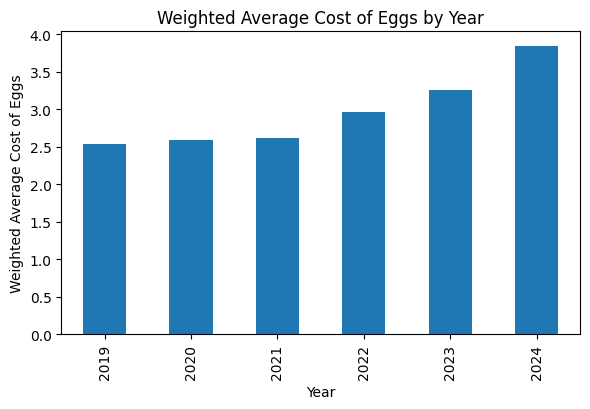

In [18]:
# Create a bar graph to represent the data
# I decided not to add the bar graph to the slides. The box plot was a better representation of the change. 
yearly_summary_compare = mean.plot(kind="bar", figsize=(6,4))
yearly_summary_compare.set_xlabel("Year")
yearly_summary_compare.set_ylabel("Weighted Average Cost of Eggs")

plt.tight_layout()
plt.title("Weighted Average Cost of Eggs by Year")

# save the figure
plt.savefig("Resources/output_data/fig2_bar.png")
plt.show()

In [19]:
# Print the dataframe for reference
year_month_summary.head()

,year,month,weighted_monthly,store_count
Year and Month,,,,
2019-01-01,2019,1,2.477714,65665.0
2019-02-01,2019,2,2.681870,76943.0
2019-03-01,2019,3,2.624465,100942.0
2019-04-01,2019,4,2.530690,103933.0
2019-05-01,2019,5,2.241598,120812.0


In [20]:
# Create a box and whisker plot to identify outliers
# Create empty list "prices" to fill with price_avg (for plotting)
price_avg_year = {}
outliers = {}
years = [2019, 2020, 2021, 2022, 2023, 2024]

    # Locate the rows for each year
for y in years:
    outliers[y] = []
    year_rows = year_month_summary[year_month_summary["year"] == y]

    quartiles = year_rows["weighted_monthly"].quantile([.25, .5, .75])
    q1 = quartiles[0.25]
    q3 = quartiles[0.75]
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    # add subset
    price_avg_year[y] = year_rows["weighted_monthly"].tolist()

    # Determine outliers using upper and lower bounds
    for p in price_avg_year[y]:
        if (p > upper_bound) or (p < lower_bound):
            outliers[y].append(p)

print(outliers)

{2019: [], 2020: [3.215346241650461], 2021: [], 2022: [], 2023: [], 2024: []}


In [21]:
outliers_series = pd.Series(outliers)

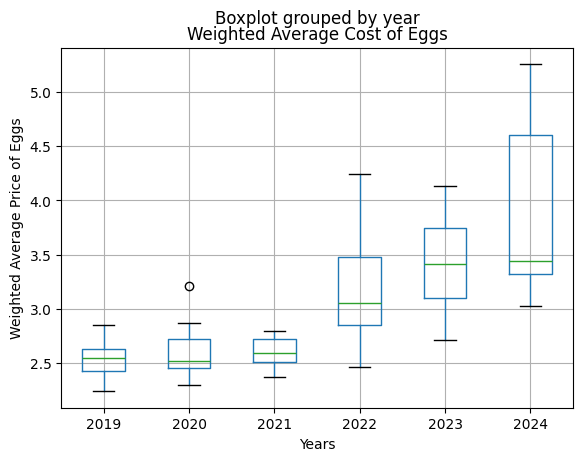

In [22]:
# Create the box and whisker plot
year_month_summary.boxplot(column="weighted_monthly", by="year")
plt.ylabel("Weighted Average Price of Eggs")
plt.xlabel("Years")
plt.title("Weighted Average Cost of Eggs")
plt.savefig("Resources/output_data/fig3_box.png")
plt.show()

## Bird Flu and 5 year Comparison

In [23]:
# Attepmt to make a line graph of the bird flu data
bf = pd.read_csv("Resources/commercial-backyard-flocks.csv")
# Filter dataframe to only commercial flocks
commercial_bf = bf.loc[(bf["Flock Type"] == "Commercial Table Egg Layer")]
# Break year and month to seperate columns
commercial_bf["Outbreak Date"] = pd.to_datetime(commercial_bf["Outbreak Date"])
commercial_bf["year"] = commercial_bf["Outbreak Date"].dt.year
commercial_bf["month"] = commercial_bf["Outbreak Date"].dt.month

commercial_bf.head()

/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_33599/4106621456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commercial_bf["Outbreak Date"] = pd.to_datetime(commercial_bf["Outbreak Date"])
/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_33599/4106621456.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commercial_bf["year"] = commercial_bf["Outbreak Date"].dt.year
/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_33599/4106621456.py:8: SettingWithCopyWarning: 
A valu

,County,State,Outbreak Date,Flock Type,Flock Size,year,month
0,Riverside,California,2024-12-31,Commercial Table Egg Layer,181300,2024,12
18,Sonoma,California,2023-12-28,Commercial Table Egg Layer,52400,2023,12
19,Sonoma,California,2023-12-28,Commercial Table Egg Layer,37300,2023,12
27,Darke,Ohio,2024-12-27,Commercial Table Egg Layer,931300,2024,12
42,Merced,California,2023-12-26,Commercial Table Egg Layer,709000,2023,12


In [38]:
yearly_summary = year_month_summary.reset_index()
yearly_summary.head()

,Year and Month,year,month,weighted_monthly,store_count
0,2019-01-01,2019,1,2.477714,65665.0
1,2019-02-01,2019,2,2.681870,76943.0
2,2019-03-01,2019,3,2.624465,100942.0
3,2019-04-01,2019,4,2.530690,103933.0
4,2019-05-01,2019,5,2.241598,120812.0


/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_33599/2635131994.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commercial_bf['Flock Size Scaled'] = commercial_bf['Flock Size'] / 1e6


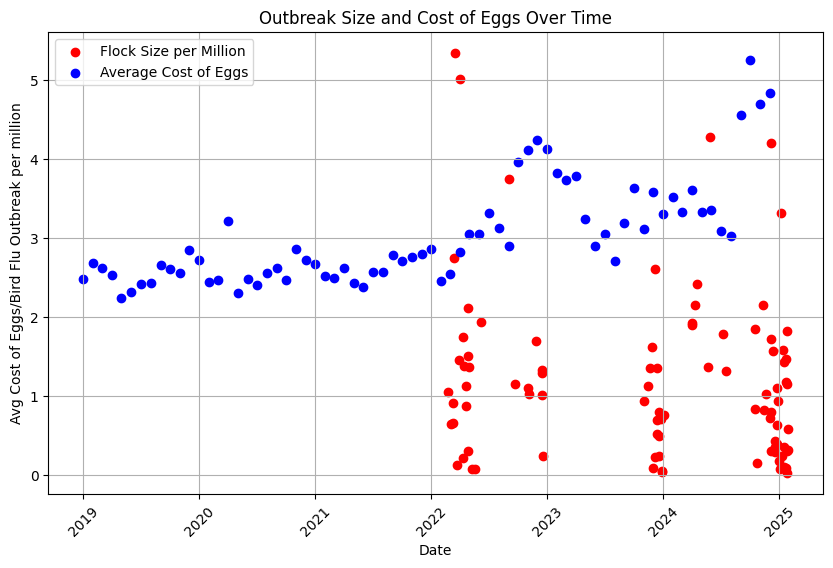

In [45]:
# Create a line scatter plot that shows both the weighted average cost of eggs and the combined outbreak numbers. 
#commercial_bf['Outbreak Date'] = pd.to_datetime(commercial_bf['Outbreak Date'], format='%Y-%m')
#yearly_summary['Year and Month'] = pd.to_datetime(year_month_summary['Year and Month'], format='%Y-%m')

# Scale down the outbreak_size by dividing by 1,000,000
commercial_bf['Flock Size Scaled'] = commercial_bf['Flock Size'] / 1e6

plt.figure(figsize=(10,6))

plt.scatter(commercial_bf["Outbreak Date"], commercial_bf["Flock Size Scaled"], color='r', label='Flock Size per Million')
plt.scatter(yearly_summary["Year and Month"],yearly_summary["weighted_monthly"], color='b', label='Average Cost of Eggs')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Avg Cost of Eggs/Bird Flu Outbreak per million')
plt.title('Outbreak Size and Cost of Eggs Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)

# Display the plot
plt.savefig("Resources/output_data/fig4_scatter.png")
plt.show()